# DDRA - Contactless (Reduced)

## General Idea
The idea is to play only with numeric features (floats, integers or booleans) that are CONTACTLESS.

This considers a subset of the features. This is mostly a copy from 002_contactless_full_attributes that just selects the most relevant attributes.

## Initial setup
This first section just ensures that the connection to DWH works correctly.

In [ ]:
# This script connects to a Data Warehouse (DWH) using PostgreSQL. 
# This should be common for all Notebooks, but you might need to adjust the path to the `dwh_utils` module.

import sys
import os
sys.path.append(os.path.abspath("../../utils"))  # Adjust path if needed

from dwh_utils import read_credentials, create_postgres_engine, query_to_dataframe, test_connection

# --- Connect to DWH ---
creds = read_credentials()
dwh_pg_engine = create_postgres_engine(creds)

# --- Test Query ---
test_connection()

🔌 Testing connection using credentials at: /home/uri/.superhog-dwh/credentials.yml
✅ Connection successful.


## Data Extraction
In this section we extract the data.

This SQL query retrieves a clean and relevant subset of booking data for our model. It includes:
- A **unique booking ID**
- Key **numeric features** such as number of services, time between booking creation and check-in, number of nights, etc.
- Several **categorical (boolean) features** related to service usage
- A **target variable** (`has_resolution_incident`) indicating whether a resolution incident occurred

Filters applied being:
1. Bookings from **"New Dash" users** with a valid deal ID
2. Only **protected bookings**, i.e., those with Protection or Deposit Management services
3. Bookings flagged for **risk categorisation** (excluding incomplete/rejected ones)
4. Bookings that are **already completed**

The result is converted into a pandas DataFrame for further processing and modeling.


In [ ]:
# Initialise all imports needed for the Notebook
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from datetime import date
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score,
    classification_report,
    roc_curve, 
    auc,
    precision_recall_curve,
    precision_score,
    recall_score,
    fbeta_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import shap
import seaborn as sns

In [ ]:
# Query to extract data
data_extraction_query = """
WITH 
service_information AS (
	SELECT
		id_booking,
		count(DISTINCT CASE WHEN service_business_type = 'SCREENING' THEN id_booking_service_detail ELSE NULL END) AS number_of_applied_screening_services,
		count(DISTINCT CASE WHEN service_business_type = 'DEPOSIT_MANAGEMENT' THEN id_booking_service_detail ELSE NULL END) AS number_of_applied_deposit_management_services,
		count(DISTINCT CASE WHEN service_business_type = 'PROTECTION' THEN id_booking_service_detail ELSE NULL END) AS number_of_applied_protection_services,
		count(DISTINCT CASE WHEN service_name = 'WAIVER PRO' THEN id_booking ELSE NULL END)>0 AS has_waiver_pro,
		count(DISTINCT CASE WHEN service_name IN ('BASIC DAMAGE DEPOSIT','BASIC DAMAGE DEPOSIT OR BASIC WAIVER','BASIC DAMAGE DEPOSIT OR WAIVER PLUS','BASIC WAIVER','WAIVER PLUS') THEN id_booking ELSE NULL END)>0 AS has_guest_facing_waiver_or_deposit,
		count(DISTINCT CASE WHEN service_name = 'GUEST AGREEMENT' THEN id_booking ELSE NULL END)>0 AS has_guest_agreement,
		count(DISTINCT CASE WHEN service_name = 'BASIC PROTECTION' THEN id_booking ELSE NULL END)>0 AS has_basic_protection,
		count(DISTINCT CASE WHEN service_name = 'PROTECTION PLUS' THEN id_booking ELSE NULL END)>0 AS has_protection_plus,
		count(DISTINCT CASE WHEN service_name = 'PROTECTION PRO' THEN id_booking ELSE NULL END)>0 AS has_protection_pro,
		count(DISTINCT CASE WHEN service_name = 'ID VERIFICATION' THEN id_booking ELSE NULL END)>0 AS has_id_verification,
		count(DISTINCT CASE WHEN service_name = 'SCREENING PLUS' THEN id_booking ELSE NULL END)>0 AS has_screening_plus,
		count(DISTINCT CASE WHEN service_name = 'SEX OFFENDER CHECK' THEN id_booking ELSE NULL END)>0 AS has_sex_offender_check
	FROM
		intermediate.int_core__booking_service_detail
	GROUP BY
		1
),
listing_information AS (
SELECT 
	ica.id_accommodation,
	-- Defaults to 0 if null
	COALESCE(ica.number_of_bedrooms, 0) AS listing_number_of_bedrooms,
	-- Defaults to 0 if null
	COALESCE(ica.number_of_bathrooms, 0) AS listing_number_of_bathrooms
	FROM intermediate.int_core__accommodation ica 
),
raw_bookings_checked_in_prior_to_TCR AS (
	SELECT
		b.id_booking,
		-- Using group by on check-in date to remove booking duplicates
		b2.booking_check_in_date_utc,
		-- Using min as a conservative approach to reduce outliers
		min(b2.booking_number_of_nights) AS min_booking_number_of_nights
	FROM
		intermediate.int_booking_summary b
	-- Note that by joining with BS we're only considering New Dash bookings
	LEFT JOIN intermediate.int_booking_summary b2
    ON
		b2.id_accommodation = b.id_accommodation
		-- Exclusion based on actual booking creation!
		AND b2.booking_check_in_date_utc >= b.booking_created_date_utc - INTERVAL '30 days'
		AND b2.booking_check_in_date_utc < b.booking_created_date_utc
		-- Note that since is based on TCR we can remove Cancelled
		AND b2.booking_status NOT IN ('CANCELLED')
	GROUP BY
		b.id_booking,
		b2.booking_check_in_date_utc
),
bookings_checked_in_prior_to_TCR AS (
	SELECT
		id_booking,
		LEAST(
			count(booking_check_in_date_utc),
			30
		) AS listing_check_ins_prior_to_TCR_in_30_days,
		-- Capping
		LEAST(
			GREATEST(
				sum(min_booking_number_of_nights),
				0
			),
			30
		) AS listing_occupancy_prior_to_TCR_in_30_days
	FROM
		raw_bookings_checked_in_prior_to_TCR
	GROUP BY
		1
),
raw_known_bookings_checking_in_prior_to_TCI AS (
	SELECT
		b.id_booking,
		b.booking_check_in_date_utc,
		-- Using group by on check-in date to remove booking duplicates
		b2.booking_check_in_date_utc AS other_bookings_check_in_date_utc,
		-- Using min as a conservative approach to reduce outliers
		min(b2.booking_number_of_nights) AS min_booking_number_of_nights
	FROM
		intermediate.int_booking_summary b
	-- Note that by joining with BS we're only considering New Dash bookings
	LEFT JOIN intermediate.int_booking_summary b2
    ON
		b2.id_accommodation = b.id_accommodation
		-- Exclusion based on check-in
		AND b2.booking_check_in_date_utc >= b.booking_check_in_date_utc - INTERVAL '30 days'
		AND b2.booking_check_in_date_utc < b.booking_check_in_date_utc
		-- that are known!
		AND b2.booking_created_date_utc < b.booking_created_date_utc
		-- Note that since is based on TCI we cannot remove Cancelled
	GROUP BY
		b.id_booking,
		b.booking_check_in_date_utc,
		b2.booking_check_in_date_utc
),
known_bookings_checking_in_prior_to_TCI AS (
	SELECT
		id_booking,
		LEAST(
			count(other_bookings_check_in_date_utc),
			30
		) AS listing_known_check_ins_prior_to_TCI_in_30_days,
		-- Capping
		LEAST(
			GREATEST(
				sum(min_booking_number_of_nights),
				0
			),
			30
		) AS listing_known_occupancy_prior_to_TCI_in_30_days,
		COALESCE(
			booking_check_in_date_utc - max(other_bookings_check_in_date_utc),
			30
		) AS lead_time_between_prior_known_check_in_to_TCI_30_days
	FROM
		raw_known_bookings_checking_in_prior_to_TCI
	GROUP BY
		id_booking, 
		booking_check_in_date_utc
),
incidents_prior_to_TCP AS (
	SELECT
		b.id_booking,
		-- Using distinct count on check-in date to remove booking duplicates
		COUNT(DISTINCT b2.booking_check_in_date_utc) AS listing_incidents_prior_to_TCP_in_30_days
	FROM
		intermediate.int_booking_summary b
	LEFT JOIN intermediate.int_booking_summary b2
    ON
		b2.id_accommodation = b.id_accommodation
		-- Filter on Check Out date
		AND b2.booking_completed_date_utc >= b.booking_created_date_utc - INTERVAL '30 days'
		AND b2.booking_completed_date_utc < b.booking_created_date_utc
		AND b2.has_resolution_incident = TRUE
	GROUP BY
		b.id_booking
)
SELECT
	-- UNIQUE BOOKING ID --
	booking_summary.id_booking,
	
	-- CONTEXTUAL SERVICE INFORMATION --
	-- We're not including number_of_applied_services as it 1-correlates with upgraded services
	booking_summary.number_of_applied_upgraded_services,
    --Removed! booking_summary.number_of_applied_billable_services,
	service_information.number_of_applied_screening_services,
	service_information.number_of_applied_deposit_management_services,
	service_information.number_of_applied_protection_services,
	--Removed! service_information.has_waiver_pro,
	--Removed! service_information.has_guest_facing_waiver_or_deposit,
	--Removed! service_information.has_guest_agreement,
	--Removed! service_information.has_basic_protection,
	--Removed! service_information.has_protection_plus,
	--Removed! service_information.has_protection_pro,
	--Removed! service_information.has_id_verification,
	--Removed! service_information.has_screening_plus,
	--Removed! service_information.has_sex_offender_check,
	NOT booking_summary.has_verification_request AS is_contactless_booking,
	
	-- CONTEXTUAL LISTING INFORMATION --
	listing_information.listing_number_of_bedrooms,
	listing_information.listing_number_of_bathrooms,
	
	-- CONTEXTUAL TIMELINE OF OUR BOOKING
	-- Defaults to 0 if booking_created_date_utc > booking_check_in_date_utc
	GREATEST(booking_summary.booking_check_in_date_utc - booking_summary.booking_created_date_utc, 0) AS booking_lead_time,
	booking_summary.booking_check_out_date_utc - booking_summary.booking_check_in_date_utc AS booking_duration,
	
	-- SAME-LISTING, OTHER BOOKING INTERACTIONS: PRIOR TO TCR
	-- Removed! bookings_checked_in_prior_to_TCR.listing_check_ins_prior_to_TCR_in_30_days,
	bookings_checked_in_prior_to_TCR.listing_occupancy_prior_to_TCR_in_30_days,
	
	-- SAME-LISTING, OTHER BOOKING INTERACTIONS: PRIOR TO TCI (KNOWN)
	-- Removed! known_bookings_checking_in_prior_to_TCI.listing_known_check_ins_prior_to_TCI_in_30_days,
	known_bookings_checking_in_prior_to_TCI.listing_known_occupancy_prior_to_TCI_in_30_days,
	known_bookings_checking_in_prior_to_TCI.lead_time_between_prior_known_check_in_to_TCI_30_days,
	
	-- SAME-LISTING, OTHER BOOKING INTERACTIONS: INCIDENTAL BOOKINGS
	-- Removed! incidents_prior_to_TCP.listing_incidents_prior_to_TCP_in_30_days,
	
	-- TARGET (BOOLEAN) --
	booking_summary.has_resolution_incident

FROM
	intermediate.int_booking_summary booking_summary
LEFT JOIN service_information 
	ON
	booking_summary.id_booking = service_information.id_booking
LEFT JOIN listing_information 
	ON booking_summary.id_accommodation = listing_information.id_accommodation
LEFT JOIN bookings_checked_in_prior_to_TCR
	ON booking_summary.id_booking = bookings_checked_in_prior_to_TCR.id_booking
LEFT JOIN known_bookings_checking_in_prior_to_TCI
	ON booking_summary.id_booking = known_bookings_checking_in_prior_to_TCI.id_booking
LEFT JOIN incidents_prior_to_TCP
	ON booking_summary.id_booking = incidents_prior_to_TCP.id_booking
WHERE
	-- 1. Bookings from New Dash users with Id Deal
	booking_summary.is_user_in_new_dash = TRUE
	AND 
    booking_summary.is_missing_id_deal = FALSE
	AND
	-- 2. Protected Bookings with a Protection or a Deposit Management service
    (
		booking_summary.has_protection_service_business_type
			OR 
    booking_summary.has_deposit_management_service_business_type
	)
	AND
	-- 3. Bookings with flagging categorisation (this excludes Cancelled/Incomplete/Rejected bookings)
	booking_summary.is_booking_flagged_as_risk IS NOT NULL
	AND
	-- 4. Booking is completed
	booking_summary.is_booking_past_completion_date = TRUE


"""

# Retrieve Data from Query
df_extraction = query_to_dataframe(engine=dwh_pg_engine, query=data_extraction_query)
print(f"Total Bookings: {len(df_extraction):,}")


Total Bookings: 21,384


## Preprocessing
Preprocessing in this notebook is quite straight-forward: we just drop id booking and split the features and target.

In [ ]:
# Drop ID column
df = df_extraction.copy().drop(columns=['id_booking'])

# Separate features and target
target_col = 'has_resolution_incident'
X = df.drop(columns=[target_col])
y = df[target_col]


## Exploratory Data Analysis
In this section we focus on explore the different features.

### EDA - Dataset Overview

In [ ]:
# Shape and types
print(f"Shape: {X.shape}")

# Target distribution
print(round(100*df[target_col].value_counts(normalize=True),2))


Shape: (21384, 12)
has_resolution_incident
False    98.8
True      1.2
Name: proportion, dtype: float64


In [ ]:
# Summary statistics for numerical features
display(df.describe(include= ['number'], percentiles=[.05,.25,.5,.75,.95,.99]).T)
# Summary statistics for boolean features
summary = df.describe(include= ['bool']).T
summary['freq/count'] = summary['freq']/summary['count']
display(summary)

count       mean  \
number_of_applied_upgraded_services                 21384.0   2.664282   
number_of_applied_screening_services                21384.0   2.007903   
number_of_applied_deposit_management_services       21384.0   0.620651   
number_of_applied_protection_services               21384.0   0.727132   
listing_number_of_bedrooms                          21384.0   2.049476   
listing_number_of_bathrooms                         21384.0   1.590816   
booking_lead_time                                   21384.0  18.151422   
booking_duration                                    21384.0   4.175084   
listing_occupancy_prior_to_tcr_in_30_days           21384.0   8.780817   
listing_known_occupancy_prior_to_tci_in_30_days     21384.0   9.470913   
lead_time_between_prior_known_check_in_to_tci_3...  21384.0  15.287318   

                                                          std  min   5%  25%  \
number_of_applied_upgraded_services                  1.532038  1.0  1.0  1.0   
number_of_applied_screening_services                 0.985649  1.0  1.0  1.0   
number_of_applied_deposit_management_services        0.485814  0.0  0.0  0.0   
number_of_applied_protection_services                0.445444  0.0  0.0  0.0   
listing_number_of_bedrooms                           1.755499  0.0  0.0  1.0   
listing_number_of_bathrooms                          1.312573  0.0  0.0  1.0   
booking_lead_time                                   24.349579  0.0  0.0  2.0   
booking_duration                                     4.851055  0.0  1.0  2.0   
listing_occupancy_prior_to_tcr_in_30_days            9.260855  0.0  0.0  0.0   
listing_known_occupancy_prior_to_tci_in_30_days      9.715511  0.0  0.0  0.0   
lead_time_between_prior_known_check_in_to_tci_3...  11.424657  1.0  2.0  5.0   

                                                     50%   75%   95%    99%  \
number_of_applied_upgraded_services                  2.0   4.0   5.0    6.0   
number_of_applied_screening_services                 2.0   3.0   4.0    4.0   
number_of_applied_deposit_management_services        1.0   1.0   1.0    1.0   
number_of_applied_protection_services                1.0   1.0   1.0    1.0   
listing_number_of_bedrooms                           2.0   3.0   5.0    8.0   
listing_number_of_bathrooms                          1.0   2.0   4.0    6.0   
booking_lead_time                                    9.0  25.0  69.0  113.0   
booking_duration                                     3.0   5.0  10.0   28.0   
listing_occupancy_prior_to_tcr_in_30_days            6.0  16.0  27.0   30.0   
listing_known_occupancy_prior_to_tci_in_30_days      6.0  17.0  30.0   30.0   
lead_time_between_prior_known_check_in_to_tci_3...  11.0  30.0  30.0   30.0   

                                                      max  
number_of_applied_upgraded_services                   7.0  
number_of_applied_screening_services                  4.0  
number_of_applied_deposit_management_services         2.0  
number_of_applied_protection_services                 1.0  
listing_number_of_bedrooms                           15.0  
listing_number_of_bathrooms                          17.0  
booking_lead_time                                   220.0  
booking_duration                                    116.0  
listing_occupancy_prior_to_tcr_in_30_days            30.0  
listing_known_occupancy_prior_to_tci_in_30_days      30.0  
lead_time_between_prior_known_check_in_to_tci_3...   30.0

count unique    top   freq freq/count
is_contactless_booking   21384      2  False  13185   0.616582
has_resolution_incident  21384      2  False  21127   0.987982

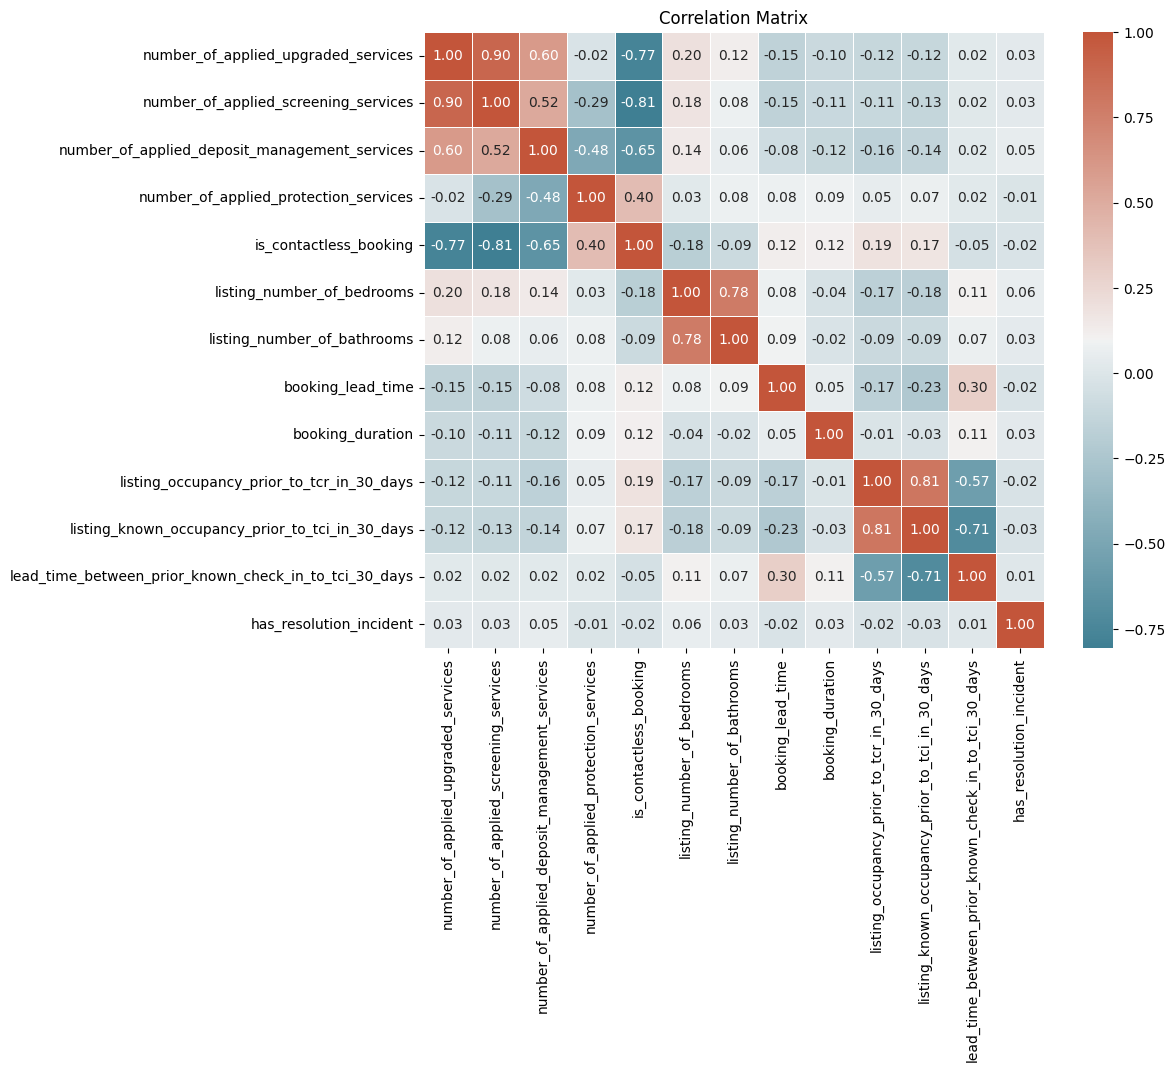

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(df.corr(), annot=True, cmap=cmap, fmt=".2f", linewidths=.5,)
plt.title("Correlation Matrix")
plt.show()

## Processing for modelling
Afterwards, we split the dataset between train and test and display their sizes and target distribution.

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

print(f"Training set size: {X_train.shape[0]} rows")
print(f"Test set size: {X_test.shape[0]} rows")

print("\nTraining target distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest target distribution:")
print(y_test.value_counts(normalize=True))

Training set size: 14968 rows
Test set size: 6416 rows

Training target distribution:
has_resolution_incident
False    0.98744
True     0.01256
Name: proportion, dtype: float64

Test target distribution:
has_resolution_incident
False    0.989246
True     0.010754
Name: proportion, dtype: float64


## Classification Model with Random Forest

We define a machine learning pipeline that includes:
- **Scaling numeric features** with `StandardScaler`
- **Training a Random Forest classifier** with balanced class weights to handle the imbalanced dataset

We then use `GridSearchCV` to perform a **grid search with cross-validation** over a range of key hyperparameters (e.g., number of trees, max depth, etc.).  
The model is evaluated using **Average Precision**, which is better suited for imbalanced classification tasks.

The best combination of parameters is selected, and the resulting model is used to make predictions on the test set.


In [ ]:

# Define pipeline (scaling numeric features only)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(class_weight='balanced', # We have an imbalanced dataset
                                     random_state=123))
])

# Define parameter grid
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt', 'log2']
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='average_precision',  # For imbalanced classification
    cv=4, # 4-fold cross-validation
    n_jobs=-1, # Use all available cores
    verbose=2, # Verbose output for progress tracking,
    refit=True # Refit the best model on the entire training set - it's already true by default
)

# Fit the grid search on training data
grid_search.fit(X_train, y_train)

# Best model
best_pipeline = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# Predict on test set
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]
y_pred = best_pipeline.predict(X_test)


Fitting 4 folds for each of 72 candidates, totalling 288 fits


[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   1.9s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   1.9s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   1.9s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   1.8s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   1.9s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   3.5s
[CV] END model__max_depth=None, model__max_features=sqrt, 

In [ ]:
# Retrieve cv results
pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5        5.800567      0.367533         0.309758        0.016611   
17       5.748260      0.156803         0.519434        0.307019   
29       4.784500      0.083096         0.176412        0.006317   
41       4.521759      0.073640         0.206560        0.009525   
16       3.828132      0.550318         0.146853        0.016658   
..            ...           ...              ...             ...   
1        3.745528      0.295001         0.159567        0.023629   
61       3.490800      0.096002         0.163926        0.008971   
49       3.569089      0.091260         0.151084        0.003098   
0        2.332713      0.932992         0.105683        0.037904   
12       2.138600      0.426632         0.101666        0.020386   

   param_model__max_depth param_model__max_features  \
5                    None                      sqrt   
17                   None                      log2   
29                     10                      sqrt   
41                     10                      log2   
16                   None                      log2   
..                    ...                       ...   
1                    None                      sqrt   
61                     20                      log2   
49                     20                      sqrt   
0                    None                      sqrt   
12                   None                      log2   

    param_model__min_samples_leaf  param_model__min_samples_split  \
5                               1                               5   
17                              1                               5   
29                              1                               5   
41                              1                               5   
16                              1                               5   
..                            ...                             ...   
1                               1                               2   
61                              1                               2   
49                              1                               2   
0                               1                               2   
12                              1                               2   

    param_model__n_estimators  \
5                         300   
17                        300   
29                        300   
41                        300   
16                        200   
..                        ...   
1                         200   
61                        200   
49                        200   
0                         100   
12                        100   

                                               params  split0_test_score  \
5   {'model__max_depth': None, 'model__max_feature...           0.032795   
17  {'model__max_depth': None, 'model__max_feature...           0.032795   
29  {'model__max_depth': 10, 'model__max_features'...           0.032233   
41  {'model__max_depth': 10, 'model__max_features'...           0.032233   
16  {'model__max_depth': None, 'model__max_feature...           0.033227   
..                                                ...                ...   
1   {'model__max_depth': None, 'model__max_feature...           0.029798   
61  {'model__max_depth': 20, 'model__max_features'...           0.031250   
49  {'model__max_depth': 20, 'model__max_features'...           0.031250   
0   {'model__max_depth': None, 'model__max_feature...           0.030112   
12  {'model__max_depth': None, 'model__max_feature...           0.030112   

    split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
5            0.020415           0.031554           0.052539         0.034326   
17           0.020415           0.031554           0.052539         0.034326   
29           0.018502           0.027846           0.058432         0.034253   
41           0.018502           0.027846           0.058432        

We apply a threshold selector to find a proper value for F2 optimisation, rather than defaulting to 0.5.

In [ ]:
# Find the best threshold for F2 score

def find_best_threshold(y_true, y_proba, beta=2.0):
    thresholds = np.linspace(0, 1, 200)
    f2_scores = []

    for t in thresholds:
        preds = (y_proba >= t).astype(int)
        score = fbeta_score(y_true, preds, beta=beta)
        f2_scores.append(score)

    best_index = np.argmax(f2_scores)
    return thresholds[best_index], f2_scores[best_index]

In [ ]:
# Predict probabilities
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Find best threshold for F2
best_thresh, best_f2 = find_best_threshold(y_test, y_pred_proba, beta=2.0)
print(f"Best threshold: {100*best_thresh:.1f}% — F2 score: {100*best_f2:.2f}%")

# Use that threshold for final classification
y_pred_opt = (y_pred_proba >= best_thresh).astype(int)

Best threshold: 5.0% — F2 score: 13.95%


## Evaluation
This section aims to evaluate how good the new model is vs. the actual Resolution Incidents.

We start by computing and displaying the classification report, ROC Curve, PR Curve and the respective Area Under the Curve (AUC).

In [ ]:
# Print classification report
print(classification_report(y_test, y_pred_opt, target_names=['No Incident', 'Incident']))

              precision    recall  f1-score   support

 No Incident       0.99      0.88      0.93      6347
    Incident       0.04      0.43      0.07        69

    accuracy                           0.87      6416
   macro avg       0.52      0.66      0.50      6416
weighted avg       0.98      0.87      0.92      6416



### Interpreting the Classification Report

The **Classification Report** provides key metrics to evaluate how well the model performed on each class.

It includes the following metrics for each class (0 and 1):
* Precision: Out of all predicted positives, how many were actually positive?
* Recall: Out of all actual positives, how many did we correctly identify?
* F1-score: Harmonic mean of precision and recall (balances both)
* Support: Number of true samples of that class in the test data

Interpretation:
* Class 0 = No incident
* Class 1 = Has resolution incident (rare, but important!)

A few explanatory cases:
* A high recall for class 1 means we're catching most incidents.
* A high precision for class 1 means when we predict an incident, we're often correct.
* The F1-score gives a single balanced measure (good for imbalanced data).

Special note for imbalanced data:
Since class 1 (or just True) is rare (1% in our case), metrics for that class are more critical.
We want to maximize recall to catch as many real incidents as possible — without letting precision drop too low (to avoid too many false alarms).

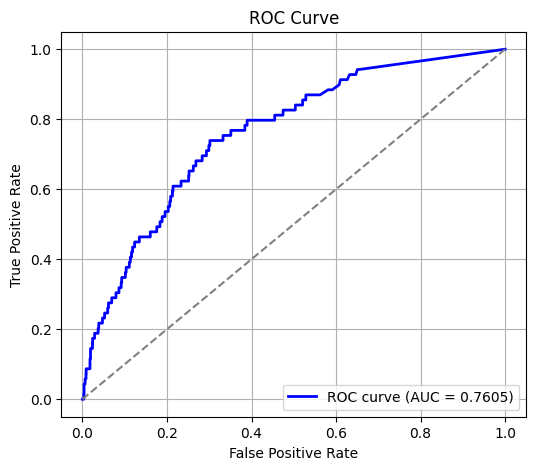

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Interpreting the ROC Curve

The **Receiver Operating Characteristic (ROC) curve** shows how well the model distinguishes between the positive and negative classes across all decision thresholds.

A quick reminder of the definitions:
* True Positive Rate (TPR) = Recall
* False Positive Rate (FPR) = Proportion of negatives wrongly classified as positives

What we display in this plot is:
* The x-axis is False Positive Rate
* The y-axis is True Positive Rate

The curve shows how TPR and FPR change as the threshold varies

It's important to note that:
* A model with no skill will produce a diagonal line (AUC = 0.5)
* A model with perfect discrimination will hug the top-left corner (AUC = 1.0)

The Area Under the Curve (ROC AUC) gives a single performance score:
* Closer to 1 means better at ranking positive cases higher than negative ones

**Important!**

While useful, the ROC curve can sometimes overestimate performance when the dataset is imbalanced, because it includes negatives (which dominate in our case, around 99%!). That’s why we also MUST check the Precision-Recall curve.

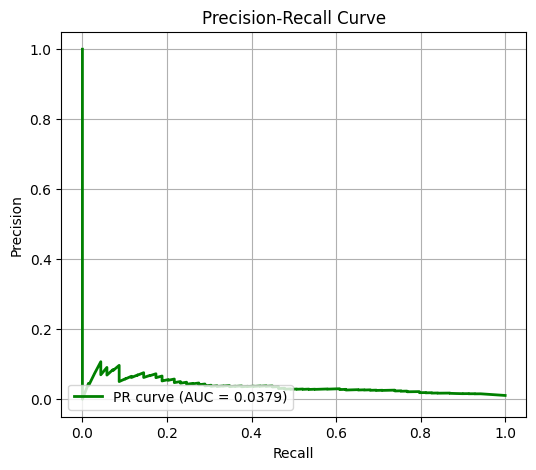

In [ ]:
# PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

### Interpreting the Precision-Recall (PR) Curve

The **Precision-Recall (PR) curve** helps evaluate model performance, especially on imbalanced datasets like ours (where positive cases are rare).

A quick reminder of the definitions:
* Precision = How many of the predicted positives are actually positive
* Recall = How many of the actual positives the model correctly identifies

What we display in this plot is:
* The x-axis is Recall 
* The y-axis is Precision 

The curve shows the trade-off between them at different model thresholds

In imbalanced datasets, accuracy can be misleading — the PR curve focuses only on the positive class, making it much more meaningful:
* A higher curve means better performance
* The area under the curve (PR AUC) summarizes this: closer to 1 is better

In [ ]:

# Compute confusion matrix: [ [TN, FP], [FN, TP] ]
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_opt).ravel()

# Total predictions
total = tp + tn + fp + fn

# Compute all requested metrics
recall = recall_score(y_test, y_pred_opt)
precision = precision_score(y_test, y_pred_opt)
f1 = fbeta_score(y_test, y_pred_opt, beta=1)
f2 = fbeta_score(y_test, y_pred_opt, beta=2)
f3 = fbeta_score(y_test, y_pred_opt, beta=3)
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0

# Scores relative to total
tp_score = tp / total
tn_score = tn / total
fp_score = fp / total
fn_score = fn / total

# Create DataFrame
summary_df = pd.DataFrame([{
    "flagging_analysis_type": "RISK_VS_CLAIM",
    "count_total": total,
    "count_true_positive": tp,
    "count_true_negative": tn,
    "count_false_positive": fp,
    "count_false_negative": fn,
    "true_positive_score": tp_score,
    "true_negative_score": tn_score,
    "false_positive_score": fp_score,
    "false_negative_score": fn_score,
    "recall_score": recall,
    "precision_score": precision,
    "false_positive_rate_score": fpr,
    "f1_score": f1,
    "f2_score": f2,
    "f3_score": f3,
    "roc_auc_score": roc_auc,
    "pr_auc_score": pr_auc
}])

In [ ]:
def plot_confusion_matrix_from_df(df, flagging_analysis_type, name_of_the_experiment=""):

    # Subset - just retrieve one row depending on the flagging_analysis_type
    row = df[df['flagging_analysis_type'] == flagging_analysis_type].iloc[0]

    # Define custom x-axis labels and wording
    if flagging_analysis_type == 'RISK_VS_CLAIM':
        x_labels = ['With Submitted Claim', 'Without Submitted Claim']
        outcome_label = "submitted claim"
    elif flagging_analysis_type == 'RISK_VS_SUBMITTED_PAYOUT':
        x_labels = ['With Submitted Payout', 'Without Submitted Payout']
        outcome_label = "submitted payout"
    else:
        x_labels = ['Actual Positive', 'Actual Negative']  
        outcome_label = "outcome"

    # Confusion matrix structure
    cm = np.array([
        [row['count_true_positive'], row['count_false_positive']],
        [row['count_false_negative'], row['count_true_negative']]
    ])

    # Create annotations for the confusion matrix
    labels = [['True Positives', 'False Positives'], ['False Negatives', 'True Negatives']]
    counts = [[f"{v:,}" for v in [row['count_true_positive'], row['count_false_positive']]],
              [f"{v:,}" for v in [row['count_false_negative'], row['count_true_negative']]]]
    percentages = [[f"{round(100*v,2):,}" for v in [row['true_positive_score'], row['false_positive_score']]],
                   [f"{round(100*v,2):,}" for v in [row['false_negative_score'], row['true_negative_score']]]]
    annot = [[f"{labels[i][j]}\n{counts[i][j]} ({percentages[i][j]}%)" for j in range(2)] for i in range(2)]

    # Scores formatted as percentages
    recall = row['recall_score'] * 100
    precision = row['precision_score'] * 100
    f1 = row['f1_score'] * 100
    f2 = row['f2_score'] * 100
    f3 = row['f3_score'] * 100
    roc_auc = row['roc_auc_score'] * 100
    pr_auc = row['pr_auc_score'] * 100

    # Set up figure and axes manually for precise control
    fig = plt.figure(figsize=(9, 8))
    grid = fig.add_gridspec(nrows=3, height_ratios=[1, 15, 2])

    
    ax_main_title = fig.add_subplot(grid[0])
    ax_main_title.axis('off')
    ax_main_title.set_title(f"{name_of_the_experiment} - Flagged as Risk vs. {outcome_label.title()}", fontsize=14, weight='bold')

    # Heatmap
    ax_heatmap = fig.add_subplot(grid[1])
    ax_heatmap.set_title(f"Confusion Matrix – Risk vs. {outcome_label.title()}", fontsize=12, weight='bold', ha='center', va='center', wrap=False)

    cmap = sns.light_palette("#A73A52", as_cmap=True)

    sns.heatmap(cm, annot=annot, fmt='', cmap=cmap, cbar=False,
                xticklabels=x_labels,
                yticklabels=['Flagged as Risk', 'Flagged as No Risk'],
                ax=ax_heatmap,
                linewidths=1.0,
                annot_kws={'fontsize': 10, 'linespacing': 1.2})
    ax_heatmap.set_xlabel("Resolution Outcome (Actual)", fontsize=11, labelpad=10)
    ax_heatmap.set_ylabel("Flagging (Prediction)", fontsize=11, labelpad=10)
    
    # Make borders visible
    for _, spine in ax_heatmap.spines.items():
        spine.set_visible(True)

    # Footer with metrics and date
    ax_footer = fig.add_subplot(grid[2])
    ax_footer.axis('off')
    metrics_text = f"Total Booking Count: {row['count_total']}  |  Recall: {recall:.2f}%  |  Precision: {precision:.2f}%  |  F1 Score: {f1:.2f}%  |  F2 Score: {f2:.2f}%  |  ROC AUC: {roc_auc:.2f}%  |  PR AUC: {pr_auc:.2f}%"
    date_text = f"Generated on {date.today().strftime('%B %d, %Y')}"
    ax_footer.text(0.5, 0.7, metrics_text, ha='center', fontsize=9)
    ax_footer.text(0.5, 0.1, date_text, ha='center', fontsize=8, color='gray')

    plt.tight_layout()
    plt.show()

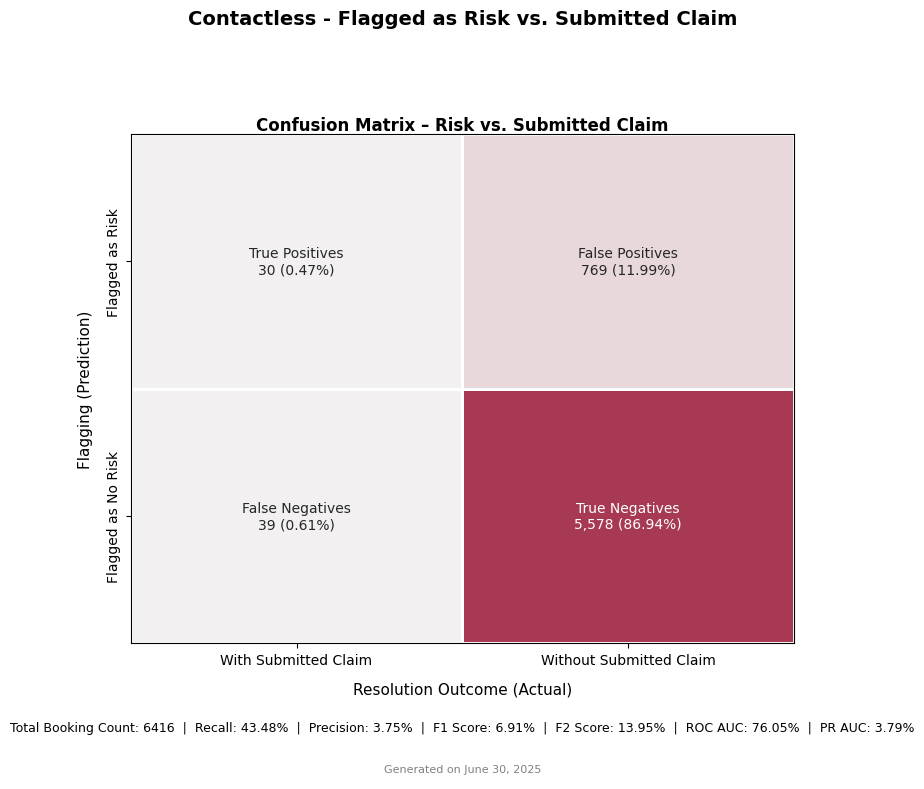

In [ ]:
# Plot confusion matrix for claim scenario
plot_confusion_matrix_from_df(summary_df, 'RISK_VS_CLAIM', 'Contactless')

## Feature Importance
Understanding what drives the prediction is useful for future experiments and business knowledge. Here we track both the native feature importances of the trees, as well as a more heavy SHAP values analysis.

Important! Be aware that SHAP analysis might take quite a bit of time.

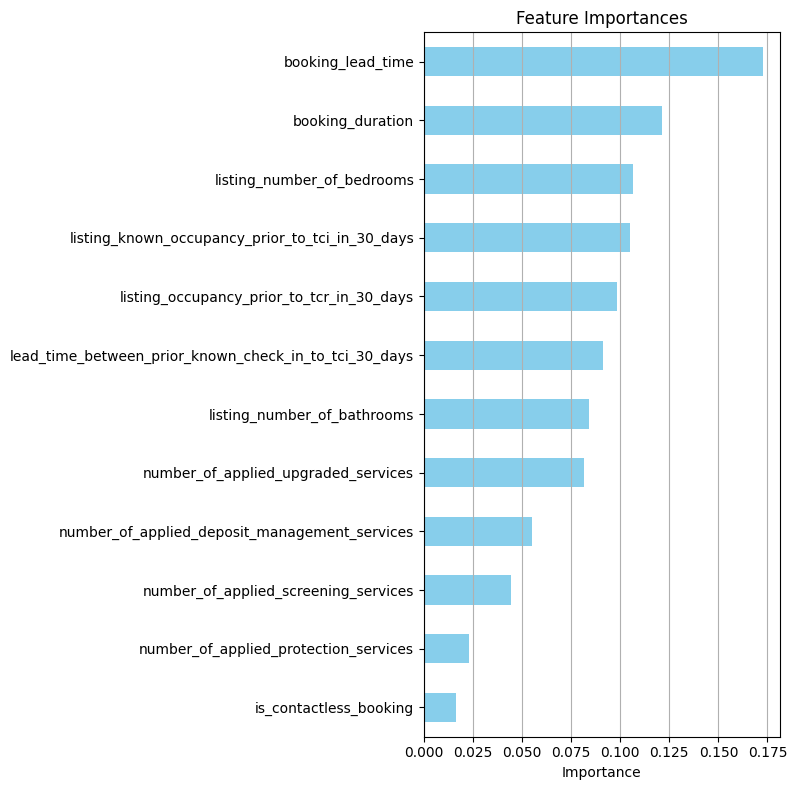

In [ ]:
## BUILT-IN

# Get feature importances from the model
importances = best_pipeline.named_steps['model'].feature_importances_
features = X.columns

# Create a Series and sort
feat_series = pd.Series(importances, index=features).sort_values(ascending=True)  # ascending=True for horizontal plot

# Plot Feature Importances
plt.figure(figsize=(8, 8))
feat_series.plot(kind='barh', color='skyblue')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

### Interpreting the Feature Importance Plot
The **feature importance plot** shows how much each feature contributes to the model’s overall decision-making.

For tree-based models like Random Forest, importance is based on how often and how effectively a feature is used to split the data across all trees.
A higher score means the feature plays a bigger role in improving prediction accuracy.

In the graph you will see that:
* Features are ranked from most to least important.
* The values are relative and model-specific — not directly interpretable as weights or probabilities.

This helps us identify which features the model relies on most when making predictions.

**Important!**
Unlike SHAP values, native importance doesn't show how a feature affects predictions — only how useful it is to the model overall. For deeper interpretability (e.g., direction and context), SHAP is better (but it takes more time to run).

In [ ]:
## SHAP VALUES

# SHAP requires that all features passed to Explainer be numeric (floats/ints)
X_test_shap = X_test.copy()
X_test_shap = X_test_shap.astype(float)

# Function that returns the probability of the positive class
def model_predict(data):
    return best_pipeline.predict_proba(data)[:, 1]

# Ensure input to SHAP is numeric
X_test_shap = X_test.astype(float)

# Create SHAP explainer
explainer = shap.Explainer(model_predict, X_test_shap)

# Compute SHAP values
shap_values = explainer(X_test_shap)

PermutationExplainer explainer: 6417it [1:26:06,  1.24it/s]                          


/tmp/ipykernel_795/3711913411.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_test_shap)


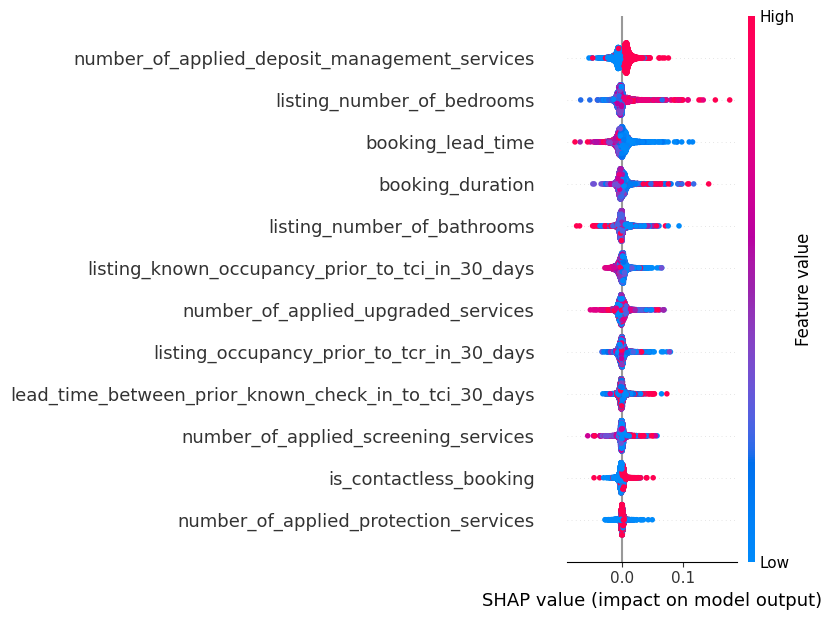

In [ ]:
# Plot summary
shap.summary_plot(shap_values.values, X_test_shap)

### Interpreting the SHAP Summary Plot

Each point on a row represents a SHAP value for a single prediction (row = feature).
The x-axis shows how much the feature contributed to increasing or decreasing the prediction.
* Right (positive SHAP value): pushes prediction toward the positive class (i.e., higher chance of incident).
* Left (negative SHAP value): pushes prediction toward the negative class (i.e., lower chance of incident).

Color shows the actual feature value for that point:
* Red = high value
* Blue = low value

In other words:
* The position tells you impact.
* The color tells you feature value.
* The density (thickness) of dots shows how often a value occurs.

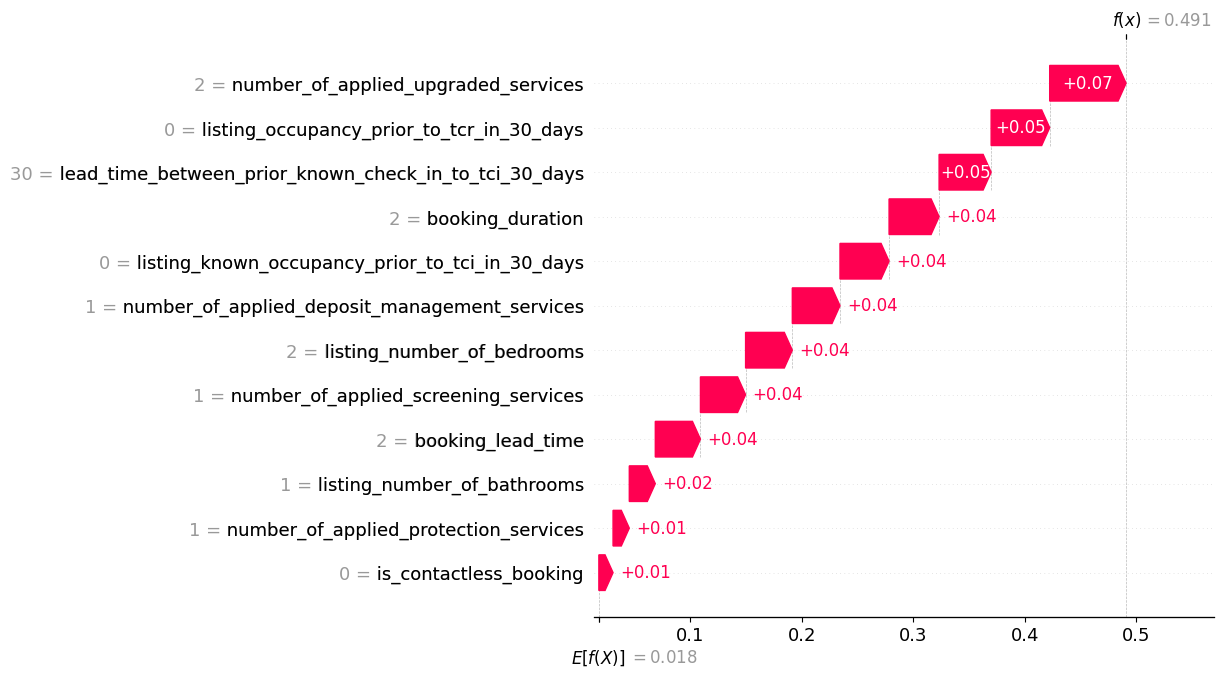

In [ ]:
# Show the individual prediction for the highest predicted instance
highest_pred_index = np.argmax(shap_values.values[:, 0]) 

# Use waterfall plot for a single instance
shap.plots.waterfall(shap_values[highest_pred_index], max_display=20)

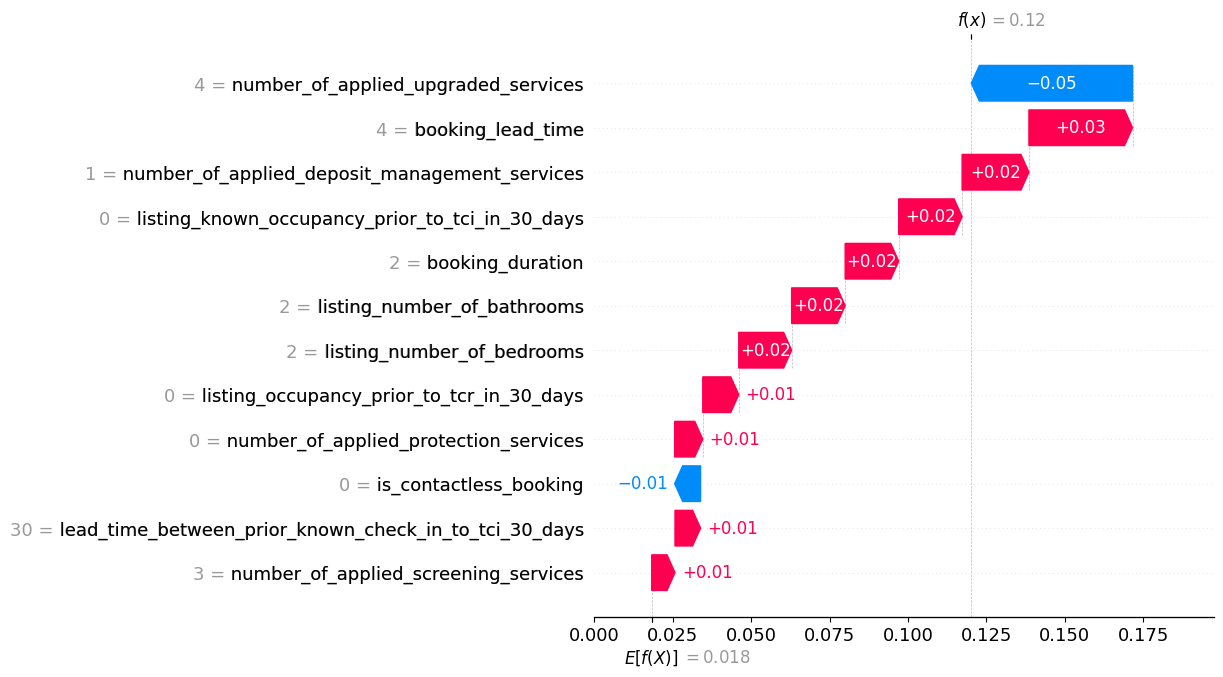

In [ ]:
# Show the individual prediction for the lowest predicted instance
lowest_pred_index = np.argmin(shap_values.values[:, 0])  

# Use waterfall plot for a single instance
shap.plots.waterfall(shap_values[lowest_pred_index], max_display=20)